Import required libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore')
import logging
import os
import ast
import pandas as pd
pd.set_option('display.max_colwidth', None)
import wandb
from simpletransformers.t5 import T5Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

Load data from CSV

In [2]:
competitors_df = pd.read_csv('./data/competitors_reddit.csv')

In [3]:
competitors_df.head()

,index,submission_id,submission_title,submission_link_flair_text,submission_selftext,reply_body
0,0,f96vya,New versions of A5 and A6 Agile firmwares are now available,NaN,"Dear Supernote users, new versions of A5 and A6 Agile firmwares are now available: \n[https://supernote.com/#/service/firmware](https://supernote.com/#/service/firmware) \n\n\n1.Add switch button of disabling hand touch function under Note file full screen mode for left-handed and avoid mis-touch.\n\n2.Add Alibaba Sans font option in EPUB document font settings to adjust space after every apostrophe. \n\n3.Add email attachment (PDF/EPUB/Note/SW files) function.\n\n4.Add QR code sharing function for notes.\n\n5.Add file sorting function.\n\n6.Modified the interactive operation of PDF trimming.\n\n7.Adjusted email signature and content display effect.","[""There was video of a multifunction button to be released in this new firmware but I can't access it -was it included in the new firmware?"", ""I had the same problem. It is there. \n\nClick the delete or selection delete button in the side bar and then click the '+' symbol on that icon and the floating menu will appear. \n\nHope that helps."", ""Please click the eraser button in the left side bar and then click '+' symbol on the icon, the copy eraser is shown on the right upper corner of menu and then double click for full screen.""]"
1,1,f9dsst,Feature request. Pressure sensitivity.,NaN,"Thank you for the new firmware update. It adds some very useful features.\n\nIs there any way that you could add pressure sensitivity adjustment/calibration in a future update? I have several styli which I find more comfortable than the Supernote stylus and the default pressure sensitivity is far too high for them. \n\nAlso, in a previous firmware version, the button on a Lamy EMR stylus triggered the selection erase tool when held down. It now does nothing. Can this be re-instated as it was a very useful feature? The eraser on other styli still works fine.\n\nThanks","['We are happy that you can enjoy this firmwares update, and your opinion is important to us.\n\nWe will fix the eraser function of Lamy EMR pen within a month, Thank you for your support.', 'Thank you for reinstating the erase feature. I see that the pressure sensitivity works correctly with the Lamy EMR Pen and Boox styli. Fantastic!', ': )']"
2,2,fp66n4,Quick Guide — Set Up and Connect to the Supernote Cloud,NaN,"Set up and connect to the Supernote Cloud account to transfer ebooks, PDFs and documents to and from your Supernote.\n\n**📷**\n\n**📷**\n\n**📷**","[""What I would like to know is where can one buy the super note in Europe. I've searched and searched but found nothing"", 'Hello, we participated in Paperworld 2020(International trade fair for stationery, office supplies and writing instruments) in 25-28 january 2020, Frankfurt am Main. You can now buy Supernote at the Goodereader store or iQoods.com and it is expected that European customers will be able to buy from our official website next month. And Supernote Amazon official store in Europe will also be available in the future.', 'Hello. International shipping is FREE now at [iQoods.com](https://www.iqoods.com) .']"
3,3,fs454n,How to use handwriting to text function?,NaN,"How do you achieve this? I've not been able to use it in notes, and sent see it in the manual?","['Currently you can try the ""Smart Writing"" function, which supports Chinese, English, Japanese handwriting recognition, text conversion and handwriting edit (including Insert/Clear/Delete/Exchange/Enter Line/Squeeze). And we are sure that this feature will be upgraded in a future update, and the ""Smart Writing"" function may be merged with Note.\n\nHow to enable Smart Writing beta:\n\nPlease enter the settings menu - click Tag - open Smart Writing']"
4,4,fs46fj,Email inbox issues,NaN,"I have set up my email, and can send emails. My inbox will not populate though...\n\nIt states there is an error and to check server settings...\n\n

Convert `reply_body` column from string to list of strings

In [4]:
competitors_df['reply_body'] = competitors_df['reply_body'].apply(ast.literal_eval)

Create new dataframe with the `prefix`, `input_text`, and `target_text` columns - the aim is to train the model on the task of ‘title prediction’, i.e. generating a title for the thread

In [5]:
title_df = pd.DataFrame()
title_df['input_text'] = competitors_df['submission_selftext'] + ' ' + competitors_df['reply_body'].apply(lambda replies: ' '.join([reply for reply in replies[:3]]))
title_df['target_text'] = competitors_df['submission_title']
title_df['prefix'] = 'title prediction'
title_df = title_df[['prefix', 'input_text', 'target_text']]

In [6]:
title_df.head()

,prefix,input_text,target_text
0,title prediction,"Dear Supernote users, new versions of A5 and A6 Agile firmwares are now available: \n[https://supernote.com/#/service/firmware](https://supernote.com/#/service/firmware) \n\n\n1.Add switch button of disabling hand touch function under Note file full screen mode for left-handed and avoid mis-touch.\n\n2.Add Alibaba Sans font option in EPUB document font settings to adjust space after every apostrophe. \n\n3.Add email attachment (PDF/EPUB/Note/SW files) function.\n\n4.Add QR code sharing function for notes.\n\n5.Add file sorting function.\n\n6.Modified the interactive operation of PDF trimming.\n\n7.Adjusted email signature and content display effect. There was video of a multifunction button to be released in this new firmware but I can't access it -was it included in the new firmware? I had the same problem. It is there. \n\nClick the delete or selection delete button in the side bar and then click the '+' symbol on that icon and the floating menu will appear. \n\nHope that helps. Please click the eraser button in the left side bar and then click '+' symbol on the icon, the copy eraser is shown on the right upper corner of menu and then double click for full screen.",New versions of A5 and A6 Agile firmwares are now available
1,title prediction,"Thank you for the new firmware update. It adds some very useful features.\n\nIs there any way that you could add pressure sensitivity adjustment/calibration in a future update? I have several styli which I find more comfortable than the Supernote stylus and the default pressure sensitivity is far too high for them. \n\nAlso, in a previous firmware version, the button on a Lamy EMR stylus triggered the selection erase tool when held down. It now does nothing. Can this be re-instated as it was a very useful feature? The eraser on other styli still works fine.\n\nThanks We are happy that you can enjoy this firmwares update, and your opinion is important to us.\n\nWe will fix the eraser function of Lamy EMR pen within a month, Thank you for your support. Thank you for reinstating the erase feature. I see that the pressure sensitivity works correctly with the Lamy EMR Pen and Boox styli. Fantastic! : )",Feature request. Pressure sensitivity.
2,title prediction,"Set up and connect to the Supernote Cloud account to transfer ebooks, PDFs and documents to and from your Supernote.\n\n**📷**\n\n**📷**\n\n**📷** What I would like to know is where can one buy the super note in Europe. I've searched and searched but found nothing Hello, we participated in Paperworld 2020(International trade fair for stationery, office supplies and writing instruments) in 25-28 january 2020, Frankfurt am Main. You can now buy Supernote at the Goodereader store or iQoods.com and it is expected that European customers will be able to buy from our official website next month. And Supernote Amazon official store in Europe will also be available in the future. Hello. International shipping is FREE now at [iQoods.com](https://www.iqoods.com) .",Quick Guide — Set Up and Connect to the Supernote Cloud
3,title prediction,"How do you achieve this? I've not been able to use it in notes, and sent see it in the manual? Currently you can try the ""Smart Writing"" function, which supports Chinese, English, Japanese handwriting recognition, text conversion and handwriting edit (including Insert/Clear/Delete/Exchange/Enter Line/Squeeze). And we are sure that this feature will be upgraded in a future update, and the ""Smart Writing"" function may be merged with Note.\n\nHow to enable Smart Writing beta:\n\nPlease enter the settings menu - click Tag - open Smart Writing",How to use handwriting to text function?
4,title prediction,"I have set up my email, and can send emails. My inbox will not populate though...\n\nIt states there is an error and to check server settings...\n\nI've logged in and out numerous times, and game tried syncing different email addresses, and have gotten the same 

Remove any rows that do not have a input text

In [7]:
title_df = title_df[~title_df['input_text'].isna()]

Split data into train and test sets

In [8]:
# train_title_df, eval_title_df = train_test_split(title_df, random_state=42, test_size=0.1)
eval_title_df = title_df.sample(frac=0.1,random_state=42)
train_title_df = title_df[~title_df.index.isin(eval_title_df.index)]

Load the training and testing data for tag classification

In [9]:
train_tag_df = pd.read_csv('./data/singletask_train.csv')
eval_tag_df = pd.read_csv('./data/singletask_noupsampling_val.csv')

Concatenate the title generation and tag classification train and test dataframes

In [10]:
train_df = pd.concat([train_title_df, train_tag_df]).reset_index(drop=True)
eval_df = pd.concat([eval_title_df, eval_tag_df]).reset_index(drop=True)

Login to Weights & Biases

In [11]:
with open('./wandb.ini', 'r') as f:
    os.environ['WANDB_API_KEY'] = f.readline().strip().split('=')[1]

Initialize transformer model

In [12]:
model_args = {
    "output_dir": './multitask', #specify output directory
    "max_seq_length": 400, # maximum sequence length in tokens
    "train_batch_size": 2, # training batch size
    "eval_batch_size": 2, # evaluation batch size
    "num_train_epochs": 4, # number of epochs
    "evaluate_during_training": True, # run evaluation during training
    #"evaluate_during_training_steps": 15000, # steps in training before eval
    "evaluate_during_training_verbose": True, # print results from evaluation during training
    "use_multiprocessing": False, # use multiprocessing when converting data into features
    "fp16": False, # use fp16 mode
    "save_steps": -1, # save a model checkpoint at every specified number of steps
    "save_eval_checkpoints": False, # save evaluation checkpoints
    "save_model_every_epoch": False, #save model checkpoint at the end of every epoch
    "reprocess_input_data": True, # reprocess the input data
    "overwrite_output_dir": True, # overwrite the output directory
    "wandb_project": "Opinion Mining - T5 - single task",
    "scheduler": "polynomial_decay_schedule_with_warmup"
}

In [13]:
model = T5Model('t5', 't5-small', use_cuda=False, args=model_args)

Train the model

In [14]:
model.train_model(train_df, eval_data=eval_df)

  0%|          | 0/1773 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

wandb: Currently logged in as: textomatic. Use `wandb login --relogin` to force relogin


Running Epoch 0 of 4:   0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

/Users/shen/opt/miniconda3/envs/opinion_mining_3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3704: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/Users/shen/opt/miniconda3/envs/opinion_mining_3/lib/python3.8/site-packages/transformers/t

Running Epoch 1 of 4:   0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

/Users/shen/opt/miniconda3/envs/opinion_mining_3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3704: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/Users/shen/opt/miniconda3/envs/opinion_mining_3/lib/python3.8/site-packages/transformers/t

Running Epoch 2 of 4:   0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

/Users/shen/opt/miniconda3/envs/opinion_mining_3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3704: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/Users/shen/opt/miniconda3/envs/opinion_mining_3/lib/python3.8/site-packages/transformers/t

  0%|          | 0/210 [00:00<?, ?it/s]

/Users/shen/opt/miniconda3/envs/opinion_mining_3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3704: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/Users/shen/opt/miniconda3/envs/opinion_mining_3/lib/python3.8/site-packages/transformers/t

Running Epoch 3 of 4:   0%|          | 0/887 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

/Users/shen/opt/miniconda3/envs/opinion_mining_3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3704: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/Users/shen/opt/miniconda3/envs/opinion_mining_3/lib/python3.8/site-packages/transformers/t

(3548,
 {'global_step': [887, 1774, 2000, 2661, 3548],
  'eval_loss': [0.4848617919066566,
   0.10484470567593927,
   0.07858381473100357,
   0.06095149300906217,
   0.06380153646522169],
  'train_loss': [0.5911074876785278,
   0.06384071707725525,
   0.05237191170454025,
   1.907344994833693e-06,
   0.00890375953167677]})

In [15]:
wandb.finish()

Training loss,▇▄▃▄▆▄█▁▂▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval_loss,█▂▁▁▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,▃▄████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
train_loss,█▂▂▁▁
Training loss,0.00051
eval_loss,0.0638
global_step,3548
lr,1e-05
train_loss,0.0089


Evaluate the model with test data for tag classification

In [16]:
model_eval_args = {
    "overwrite_output_dir": True,
    "max_seq_length": 400,
    "eval_batch_size": 4,
    "use_multiprocessing": False,
    "num_beams": 5,
    "do_sample": True,
    "max_length": 10,
    "top_k": 50,
    "top_p": 0.95,
    "num_return_sequences": 2,
}
# Load the trained model
model_eval = T5Model("t5", "multitask", use_cuda=False, args=model_eval_args)

In [17]:
# Prepare the data for testing
to_predict = [
    prefix + ": " + str(input_text)
    for prefix, input_text in zip(eval_tag_df["prefix"].tolist(), eval_tag_df["input_text"].tolist())
]
truth = eval_tag_df["target_text"].tolist()
tasks = eval_tag_df["prefix"].tolist()

In [18]:
# Prepare truth labels for testing
val_labels = eval_tag_df['target_text']

In [19]:
# Get the model predictions
preds = model_eval.predict(to_predict)

Generating outputs:   0%|          | 0/13 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/98 [00:00<?, ?it/s]

In [20]:
predicted_labels = []
for cur_pred in preds:
    cur_pred = cur_pred[0].strip()
    predicted_labels.append(cur_pred)

View classification metrics and visualize confusion matrix

In [21]:
print(classification_report(val_labels, predicted_labels))

                 precision    recall  f1-score   support

       Question       0.88      0.97      0.92        37
         Review       0.50      0.33      0.40         3
Stylus problems       0.00      0.00      0.00         1
      Templates       0.83      0.62      0.71         8

       accuracy                           0.86        49
      macro avg       0.55      0.48      0.51        49
   weighted avg       0.83      0.86      0.84        49



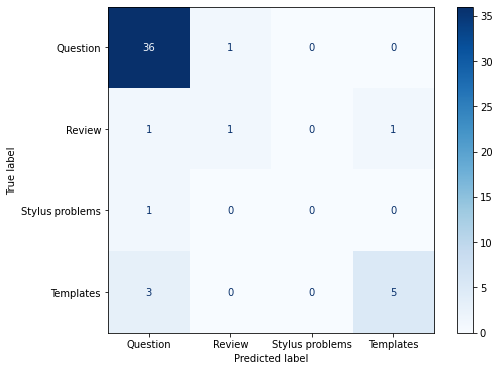

In [22]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ConfusionMatrixDisplay.from_predictions(val_labels, predicted_labels, cmap='Blues', ax=ax)